In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets
import time
import copy
import pickle

import pandas as pd

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

Using cuda device
PyTorch Version:  1.11.0
Torchvision Version:  0.12.0


In [3]:
class MyDataset(Dataset):
    # Initialization
    def __init__(self, data, label, unlabel_idx, mode='2D'):
        self.data, self.label, self.mode, self.unlabel_idx= data, label, mode, unlabel_idx

    # Get item
    def __getitem__(self, index):
        if self.mode == '2D':
            return self.data[index, :], self.label[index, :], self.unlabel_idx[index, :]
        elif self.mode == '3D':
            return self.data[:, index, :], self.label[:, index, :], self.unlabel_idx[:, index, :]

    # Get length
    def __len__(self):
        if self.mode == '2D':
            return self.data.shape[0]
        elif self.mode == '3D':
            return self.data.shape[1]

    def getNumpyLabel(self):
        return self.label.cpu().detach().numpy()
    def getTensorTrain(self):
        return self.data

In [4]:
class AE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.encoder = nn.Linear(input_dim, latent_dim, bias=True)
        self.decoder = nn.Linear(latent_dim, input_dim, bias=True)
        self.y_layer = nn.Linear(latent_dim, 1, bias=True)

    def forward(self, X, decode=True):
        # Return (latent/decode output, Y estimate by dense)
        H = torch.sigmoid(self.encoder(X))
        if decode:
            return torch.sigmoid(self.decoder(H)), torch.sigmoid(self.y_layer(H))
        else:
            return H, torch.sigmoid(self.y_layer(H))

class SAE(nn.Module):
    def __init__(self,AE_list):
        super().__init__()
        self.num_AE = len(AE_list)
        self.SAE_list=[]

        for i in range(1, self.num_AE+1):
            if i != self.num_AE:
                self.SAE_list.append(AE(AE_list[i-1], AE_list[i]).to(device))
            else:
                self.SAE_list.append(AE(AE_list[-1], AE_list[-1]).to(device))
        
        #self.y_estimate = nn.Linear(AE_list[-1],1)
    
    def wgtFromList(self, wts_list):
        for i in range(self.num_AE):
            self.SAE_list[i].load_state_dict(wts_list[i])
    
    def forward(self, x, layer_idx, preTrain = False):
        # preTrain: previous layers' parameters are frozen 
        # preTrain -> Return (input, AE_output, y estimate)
        # !preTrain -> Return last layer's (latent, estimate)
        output = x
        if preTrain:
            if layer_idx == 0:
                inputs = output
                output, y_estimate = self.SAE_list[layer_idx](output, decode=True)                
                return inputs, output, y_estimate

            else:
                for i in range(layer_idx):
                    for param in self.SAE_list[i].parameters():
                        param.requires_grad = False
                    output,_ = self.SAE_list[i](output, decode = False)
                inputs = output
                output, y_estimate = self.SAE_list[layer_idx](output, decode=True)                
                return inputs, output, y_estimate
        else:
            for i in range(self.num_AE-1):
                for param in self.SAE_list[i].parameters():
                    param.requires_grad = True
                output, _ = self.SAE_list[i](output, decode = False)
            return self.SAE_list[-1](output, decode = False)

def loss_func(input_encode, output_latent, y_estimate,  y_label, unlabel_idx, tradeoff_param):
    N_total = unlabel_idx.size(dim=0)
    N_u = torch.sum(unlabel_idx)
    N_l = N_total - N_u
    label_idx = torch.ones(unlabel_idx.size(), dtype=int, device=device)-unlabel_idx
    unlabel_term = (N_total/(2*N_u))*nn.functional.mse_loss(unlabel_idx*input_encode, unlabel_idx*output_latent)
    label_term = (N_total/(2*N_l))*(nn.functional.mse_loss(label_idx*input_encode, label_idx*output_latent)+
                    tradeoff_param*nn.functional.mse_loss(label_idx*y_estimate, label_idx*y_label))
    return unlabel_term+label_term
                                

def SAE_train(dataloader_dict, SAE_model, unsp_epochs, unsp_lr, tradeoff_param, sp_epochs, sp_lr):
    SAE_model.to(device)
    for layer_idx in range(SAE_model.num_AE):
        print('Pre-training on the {} layer'.format(layer_idx))
        # Pretraining of each layer
        optimizer = torch.optim.Adam(SAE_model.SAE_list[layer_idx].parameters(), lr = unsp_lr)
        #SAE_model.SAE_list[layer_idx].train()
        best_layer_wts = copy.deepcopy(SAE_model.SAE_list[layer_idx].state_dict())
        best_loss = np.inf

        for epoch in range(unsp_epochs):
            #print('Epoch {}/{}'.format(epoch, unsp_epochs - 1))
            for phase in ['train', 'val']:
                if phase == 'train':
                    SAE_model.SAE_list[layer_idx].train()
                else:
                    SAE_model.SAE_list[layer_idx].eval()
                
                for inputs, labels, unlabel_idx in dataloader_dict[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    unlabel_idx = unlabel_idx.to(device)
                    optimizer.zero_grad()
                    input_encode,output_latent,y_estimate = SAE_model(inputs,layer_idx,preTrain=True)
                    loss = loss_func(input_encode, output_latent, y_estimate, labels, unlabel_idx, tradeoff_param)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                loss= loss.item()
                if phase == 'train':
                    train_loss = loss
                else:
                    val_loss = loss
            print(f"Epoch {epoch+1}/{unsp_epochs}, train_loss: {train_loss:>7f}, val_loss: {val_loss:>7f}")
            if phase == 'val' and val_loss < best_loss:
                best_loss = val_loss
                best_layer_wts = copy.deepcopy(SAE_model.SAE_list[layer_idx].state_dict())
        SAE_model.SAE_list[layer_idx].load_state_dict(best_layer_wts)
        print(f'Best loss: {best_loss:>7f}')

    print('Start Finetuning\n')
    param_list=[]
    best_wts_list=[]
    for tmp_sub_model in SAE_model.SAE_list:
        best_wts_list.append(tmp_sub_model.state_dict())
        for tmp_param in tmp_sub_model.parameters():
            param_list.append(tmp_param)
    optimizer = torch.optim.Adam(param_list, lr=sp_lr)
    #SAE_model.train()
    mse_loss = nn.MSELoss()
    best_loss = np.inf

    for epoch in range(sp_epochs):
        for phase in ['train', 'val']:
            sum_loss=0
            if phase == 'train':
                SAE_model.train()
            else:
                SAE_model.eval()

            for tmp_inputs, tmp_labels, unlabel_idx in dataloader_dict[phase]:
                #inputs = inputs.to(device)
                #labels = labels.to(device)
                unlabel_idx = unlabel_idx.to(device)
                label_idx = torch.ones(unlabel_idx.size(), dtype=int, device=device)-unlabel_idx
                inputs = torch.index_select(tmp_inputs, 0, torch.argwhere(label_idx)[:,0]).to(device)
                labels = torch.index_select(tmp_labels, 0, torch.argwhere(label_idx)[:,0]).to(device)
                optimizer.zero_grad()
                _, y_estimate = SAE_model(inputs,SAE_model.num_AE-1,preTrain=False)
                #print(y_estimate)
                #print('label\n', labels)
                loss = mse_loss(y_estimate, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                sum_loss += loss.detach().item()
            if phase == 'train':
                train_loss = sum_loss
            else:
                val_loss = sum_loss
        print(f"Epoch {epoch+1}/{sp_epochs}, train_loss: {train_loss:>7f}, val_loss: {val_loss:>7f}")
        if phase == 'val' and val_loss < best_loss:
            best_loss = val_loss
            for AE_idx in range(SAE_model.num_AE):
                best_wts_list[AE_idx] = copy.deepcopy(SAE_model.SAE_list[AE_idx].state_dict())
    SAE_model.wgtFromList(best_wts_list)
    print('Training complete')
    #torch.save(SAE_model.state_dict(), "model.pth")
    with open('wts_list', 'wb') as fp:
        pickle.dump(best_wts_list, fp)
        


In [5]:
def genUnlabelList(data, label, remain = 0.2, mode = '2D'):
    if mode == '2D':
        label_idx = np.arange(0, data.shape[0], int(1/remain), dtype=int)
        unlabel_idx = np.ones((data.shape[0],1)).astype('int')
    elif mode == '3D':
        label_idx = np.arange(0, data.shape[1], int(1/remain), dtype=int)
        unlabel_idx = np.ones((data.shape[1],1)).astype('int')
    unlabel_idx[label_idx]=0
    return unlabel_idx

data = pd.read_csv('Debutanizer_Column_Data.txt', sep='\s+')
data = data.values

x_temp = data[:, :7]
y_temp = data[:, 7]


x_new = np.zeros([2390, 13])
x_6 = x_temp[:, 4]
x_9 = (x_temp[:, 5] + x_temp[:, 6])/2
x_new[:, :5] = x_temp[4: 2394, :5]

x_new[:, 5] = x_6[3: 2393]
x_new[:, 6] = x_6[2: 2392]
x_new[:, 7] = x_6[1: 2391]
x_new[:, 8] = x_9[4: 2394]

x_new[:, 9] = y_temp[3: 2393]
x_new[:, 10] = y_temp[2: 2392]
x_new[:, 11] = y_temp[1:2391]
x_new[:, 12] = y_temp[:2390]
y_new = y_temp[4: 2394]
y_new = y_new.reshape([-1, 1])

train_x = x_new[:1000, :]
train_y = y_new[:1000]

val_x = x_new[1000:1600, :]
val_y = y_new[1000:1600]

test_x = x_new[1600:2390, :]
test_y = y_new[1600:2390]

train_unlabel = genUnlabelList(train_x, train_y, remain = 0.2, mode='2D')
train_dataset = MyDataset(torch.tensor(train_x, dtype=torch.float32, device=device),
                          torch.tensor(train_y, dtype=torch.float32, device=device),
                          torch.tensor(train_unlabel, dtype=torch.int, device=device))
val_unlabel = genUnlabelList(val_x, val_y, remain = 0.2, mode='2D')
val_dataset = MyDataset(torch.tensor(val_x, dtype=torch.float32, device=device),
                          torch.tensor(val_y, dtype=torch.float32, device=device),
                          torch.tensor(val_unlabel, dtype=torch.int, device=device))
test_unlabel = genUnlabelList(test_x, test_y, remain = 0.2, mode='2D')
test_dataset = MyDataset(torch.tensor(test_x, dtype=torch.float32, device=device),
                          torch.tensor(test_y, dtype=torch.float32, device=device),
                          torch.tensor(test_unlabel, dtype=torch.int, device=device))

# Key params
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
dataloader_dict ={'train' : train_dataloader, 'val' : val_dataloader}

In [6]:
myModel = SAE(AE_list=[13,10,7,5])
SAE_train(dataloader_dict , myModel, 50, 0.01, 1.6, 100, 0.01)

Pre-training on the 0 layer
Epoch 1/50, train_loss: 0.010389, val_loss: 0.071277
Epoch 2/50, train_loss: 0.008566, val_loss: 0.083016
Epoch 3/50, train_loss: 0.007035, val_loss: 0.082533
Epoch 4/50, train_loss: 0.006427, val_loss: 0.082096
Epoch 5/50, train_loss: 0.006285, val_loss: 0.081615
Epoch 6/50, train_loss: 0.006257, val_loss: 0.080887
Epoch 7/50, train_loss: 0.006223, val_loss: 0.080653
Epoch 8/50, train_loss: 0.006220, val_loss: 0.080443
Epoch 9/50, train_loss: 0.006187, val_loss: 0.080075
Epoch 10/50, train_loss: 0.006148, val_loss: 0.079691
Epoch 11/50, train_loss: 0.006112, val_loss: 0.079318
Epoch 12/50, train_loss: 0.006068, val_loss: 0.078916
Epoch 13/50, train_loss: 0.006017, val_loss: 0.078494
Epoch 14/50, train_loss: 0.005964, val_loss: 0.078069
Epoch 15/50, train_loss: 0.005906, val_loss: 0.077622
Epoch 16/50, train_loss: 0.005843, val_loss: 0.077181
Epoch 17/50, train_loss: 0.005779, val_loss: 0.076749
Epoch 18/50, train_loss: 0.005713, val_loss: 0.076336
Epoch 19/

In [7]:
myModel.eval()
with torch.no_grad():
    _,pred = myModel(torch.tensor(test_x, dtype=torch.float32, device=device),0)

In [6]:
loadModel = SAE(AE_list=[13,10,7,5])
#torch.save(model.state_dict(), PATH)
#loadModel.load_state_dict(torch.load('model.pth'))
with open('wts_list', 'rb') as fp:
    wts_list = pickle.load(fp)
loadModel.wgtFromList(wts_list)
loadModel.eval()
with torch.no_grad():
    _,pred = loadModel(torch.tensor(test_x, dtype=torch.float32, device=device),0)

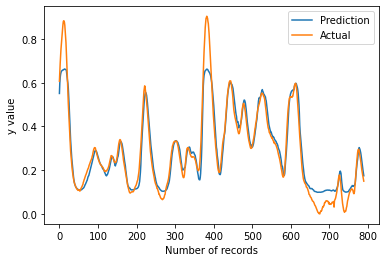

In [8]:
plt.plot(pred.cpu().detach().numpy(), label='Prediction')
plt.plot(test_y, label='Actual')
plt.xlabel('Number of records')
plt.ylabel('y value')
plt.legend()

In [171]:
train_y

array([[0.16697247],
       [0.16367888],
       [0.1602487 ],
       [0.1582424 ],
       [0.1570443 ],
       [0.15479179],
       [0.1547679 ],
       [0.15598922],
       [0.15584463],
       [0.15703897],
       [0.15915777],
       [0.16383627],
       [0.16700677],
       [0.17250859],
       [0.17834621],
       [0.18713385],
       [0.19605279],
       [0.20504501],
       [0.20952408],
       [0.21723898],
       [0.22518005],
       [0.23545468],
       [0.2410065 ],
       [0.24419737],
       [0.24873731],
       [0.2509001 ],
       [0.24885268],
       [0.25192147],
       [0.25753295],
       [0.2642149 ],
       [0.27009967],
       [0.27675261],
       [0.27988109],
       [0.28342946],
       [0.28342662],
       [0.28338823],
       [0.28115132],
       [0.28221239],
       [0.28340843],
       [0.2853386 ],
       [0.28649487],
       [0.29006141],
       [0.2932166 ],
       [0.29326265],
       [0.29561323],
       [0.29998999],
       [0.30900097],
       [0.316